In [1]:
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import scanpy
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import scanpy as sc
from sklearn.decomposition import PCA
from umap import UMAP
from tqdm import tqdm
import squidpy as sq
import re

2023-06-02 07:11:43.214439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 07:11:44.267110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
QUALITY = "fullres"

In [16]:
current_folder = globals()["_dh"][0]
input_dir = current_folder / ".." / ".." / "data" / ("image_features_" + QUALITY)
output_dir = current_folder / ".." / ".." / "out" / "deep_image_features_eval"
metadata_path = current_folder / ".." / ".." / "data" / "Metadata_all.xlsx"
metadata = pd.read_excel(metadata_path, index_col=0, sheet_name="Visium")
samples = [re.sub(".h5ad", "", f) for f in os.listdir(input_dir) if not f.startswith(".") and f.endswith(".h5ad")]

In [26]:
# make a lookup table for sample names and lesion type where sample_id is the key and lesion_type the value using metadata df
sample_lesion_dict = dict(zip(metadata.sample_id, metadata["lesion_type"]))
sample_lesion_dict

{'MS94': 'CA',
 'MS197U': 'CA',
 'MS197D': 'CA',
 'MS229': 'CA',
 'MS371': 'A',
 'MS371N': 'A',
 'MS377N': 'CA',
 'MS377I': 'CA',
 'MS377T': 'CA',
 'MS411': 'CA',
 'MS466': 'CI',
 'MS497I': 'CI',
 'MS497T': 'CI',
 'MS549H': 'CI',
 'MS549T': 'CI',
 'MS586': 'A',
 'CO37': 'Ctrl',
 'CO40': 'Ctrl',
 'CO41': 'Ctrl',
 'CO74': 'Ctrl',
 'CO85': 'Ctrl',
 'CO96': 'Ctrl'}

In [18]:
adata_dict = {sample: sc.read_h5ad(input_dir / (sample + ".h5ad")) for sample in samples}
cond_vec = np.array(["MS" if s.startswith("MS") else "HC" for s in adata_dict.keys()])
stage_vec = np.array([sample_lesion_dict[sample] if sample in sample_lesion_dict.keys() else "NA" for sample in adata_dict.keys()])

# Mean per image feature

In [19]:
image_features = np.array([adata.obsm["image_features"].mean(axis=0) for adata in adata_dict.values()])
print(image_features.shape)
pca_coord = PCA(n_components=min(image_features.shape)).fit_transform(image_features)
print(pca_coord.shape)
umap_coord = UMAP(n_components=2).fit_transform(pca_coord)
print(umap_coord.shape)

(22, 2048)

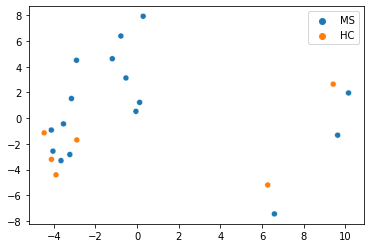

In [23]:
sns.scatterplot(x=pca_coord[:, 0], y=pca_coord[:, 1], hue=cond_vec)
plt.show()

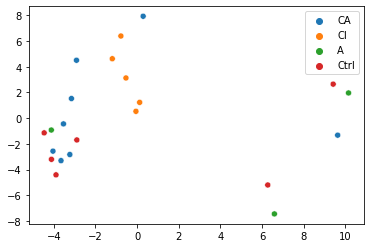

In [27]:
sns.scatterplot(x=pca_coord[:, 0], y=pca_coord[:, 1], hue=stage_vec)
plt.show()

# Cluster cells based on image feature space and compute fractions of clusters per image

In [11]:
image_features_mtx = np.vstack([adata.obsm["image_features"] for adata in adata_dict.values()])
image_features_adata = scanpy.AnnData(image_features_mtx)
image_features_adata.obs = pd.concat([adata.obs for adata in adata_dict.values()])
image_features_adata.obs["sample_id"] = np.hstack([np.repeat(sample, len(adata_dict[sample])) for sample in samples])
image_features_adata.obs["lesion_type"] = image_features_adata.obs["sample_id"].map(sample_lesion_dict)
sc.pp.pca(image_features_adata)
sc.external.pp.bbknn(image_features_adata, batch_key="sample_id") # maybe this integration step helps
# sc.pp.neighbors(image_features_adata) # this is the alternaive
image_features_adata

AnnData object with n_obs × n_vars = 56287 × 2048
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'sample_id', 'lesion_type'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [12]:
sc.tl.leiden(image_features_adata, resolution=2)
image_features_adata

AnnData object with n_obs × n_vars = 56287 × 2048
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'sample_id', 'lesion_type', 'leiden'
    uns: 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [13]:
# count number of cells per cluster per sample
cluster_counts = image_features_adata.obs.groupby(["sample_id", "leiden"]).size().reset_index()
cluster_counts = cluster_counts.pivot(index="sample_id", columns="leiden", values=0)
cluster_counts = cluster_counts.fillna(0)
cluster_counts = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

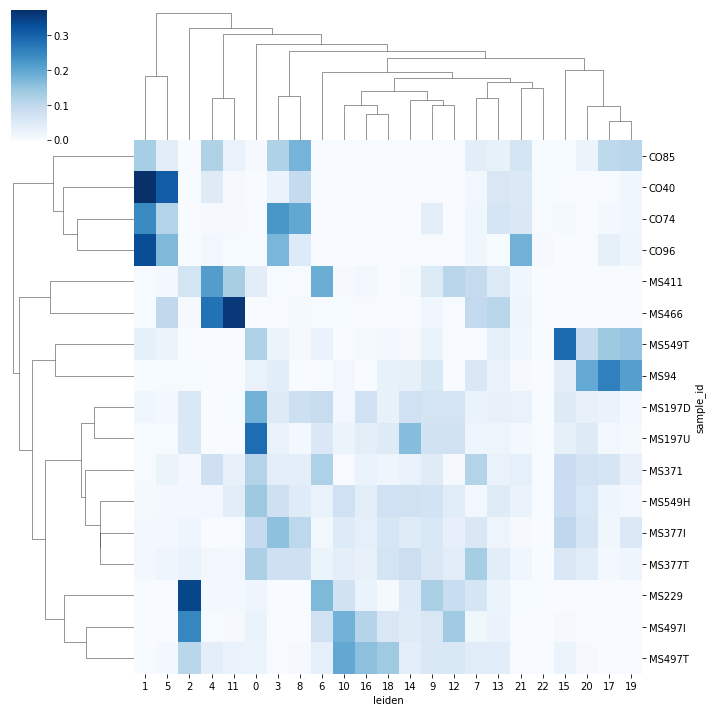

In [14]:
# heatmap with hierarchical clustering
sns.clustermap(cluster_counts, cmap="Blues")
plt.show()

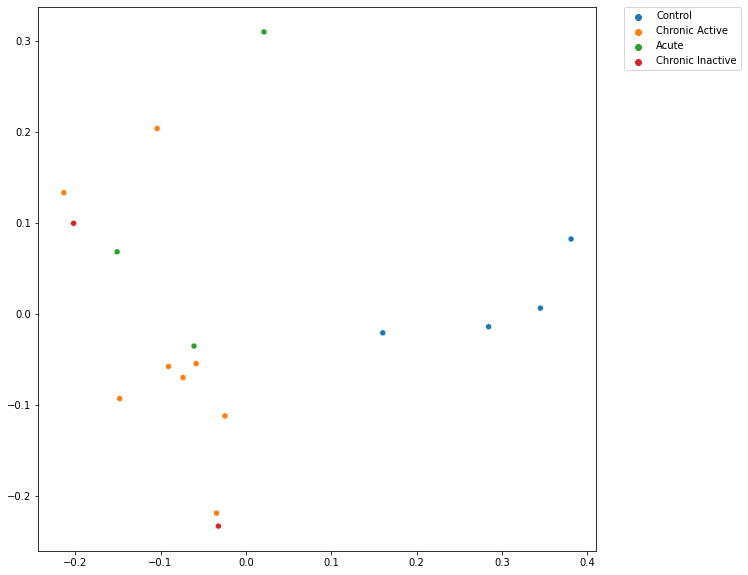

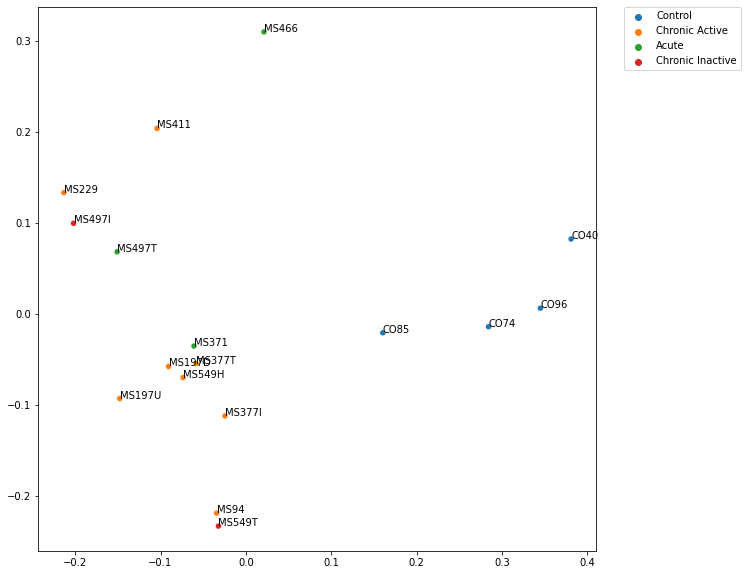

In [15]:
pca_coord_3 = PCA(n_components=min(cluster_counts.shape)).fit_transform(cluster_counts)

# same plot as above but label the points using the cluster_counts.index by writing the text in the plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=pca_coord_3[:, 0], y=pca_coord_3[:, 1], hue=[sample_lesion_dict[s] for s in cluster_counts.index])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.clf()
plt.cla()
plt.close()


# same plot as above but label the points using the cluster_counts.index by writing the text in the plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=pca_coord_3[:, 0], y=pca_coord_3[:, 1], hue=[sample_lesion_dict[s] for s in cluster_counts.index])
for i, txt in enumerate(cluster_counts.index):
    plt.annotate(txt, (pca_coord_3[i, 0], pca_coord_3[i, 1]))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.clf()
plt.cla()
plt.close()